# Iterative Deepening A* (IDA*) Algorithm 

The requirement to store the `A*` search tree in memory (`Closed` and `Open` sets) can become a limiting factor for certain problems. The renowned **n-puzzle** (or Gem Puzzle) game is a prime example, particularly when $n > 3$. A potential solution to this challenge is to combine the iterative deepening technique with A*. This approach is known as the IDA* algorithm [(Korf, 1985)](https://academiccommons.columbia.edu/doi/10.7916/D8BK1M9V/download).

In this lab, your task is to implement the `IDA*` algorithm for the n-puzzle game and then contrast its performance with `A*`, focusing primarily on runtime and memory usage metrics. To commence, you will need to create your own benchmark.

Best of luck!

(Korf, 1985) Korf, R.E., 1985. Depth-first iterative-deepening: An optimal admissible tree search. Artificial intelligence, 27(1), pp.97-109. [[PDF](https://academiccommons.columbia.edu/doi/10.7916/D8BK1M9V/download)]

In [1]:
from random import shuffle
import copy
import numpy as np
import matplotlib.pyplot as plt
import math
from heapq import heappop, heappush
from typing import Tuple, List, Iterable, Callable, Type, Dict, Union, Optional, Set
import numpy.typing as npt

%matplotlib inline

STEP_COST = 1

## Gem Puzzle (15-puzzle or n-puzzle)
### Representation of a search state

Indeed, there may exist many ways to represent a search state for the Gem Puzzle. In this lab, we will use a list of integers as an external encoding of the Gem Puzzle state. This list is assumed to contain numbers from 1 to (*size* * *size*), where *size* is the size of the puzzle. The tile with the number *size* * *size* is a blank tile.

For example, the encoding of the start state of the 8-puzzle depicted above will be \[7,2,4,5,9,6,8,3,1\].

In [2]:
class GemPuzzleState:
    """
    Implementing a search state (or simply, a state) in code is a crucial first step
    necessary for tackling any search problem. The `GemPuzzleState` class is structured
    with the following fields:

    Attributes
    ----------
    size : int
        Width of the game field.

    tile_list : Optional[List[int]]
        Tile positions represented as a list of integers from 1 to (size x size).
        Each integer corresponds to a tile's value, and its index represents its position
        on the game field. The tile with the maximum value is considered the blank.

    parent : GemPuzzleState
        A pointer to the parent state. The parent is a predecessor of the state in
        the search tree. It is used to reconstruct a path to that state from the start
        state (the root of the search tree).

    blank_pos : int
        The position of the empty tile in tile_list. Explicitly
        storing the position of a blank helps to generate successors faster.
    """

    def __init__(self, tile_list: Optional[List[int]] = None):
        """
        Constructor. Sets tile positions and performs some basic checks.

        Parameters
        ----------
        tile_list : List[int]
            Tile positions as a list of integers from 1 to `size * size`.
            The tile with value `size * size` represents the blank position.
        """
        if tile_list is None:
            self.size = None
            self.blank_pos = None
            return

        self.tile_list = tile_list
        self.size = int(len(tile_list) ** 0.5)

        if len(tile_list) != self.size**2:
            raise ValueError("Tile list size should be a perfect square.")

        # Finding the position of the blank tile
        blank_value = self.size**2
        self.blank_pos = self.tile_list.index(blank_value) if blank_value in self.tile_list else -1

        if self.blank_pos == -1:
            raise ValueError("State should contain max value indicating the blank tile's position.")

    def __eq__(self, other) -> bool:
        """
        Compares one state with another based on their tile lists.
        """
        return hash(self) == hash(other) and self.tile_list == other.tile_list

    def __str__(self) -> str:
        """
        Return a string representation of the game field for printing.
        """
        blank_value = self.size**2
        tile_matrix = np.array(self.tile_list).reshape(self.size, self.size)
        result = (
            str(tile_matrix).replace(" [", "").replace("[", "").replace("]", "").replace(str(blank_value), "_") + "\n"
        )
        return result

    def __hash__(self):
        return hash(str(self.tile_list))

### Get Succesors

In [3]:
def get_successors(state: GemPuzzleState) -> List[GemPuzzleState]:
    """
    Implementing the `get_successors` function is another crucial step in tackling any search problem.
    This function is designed to take a specific search state as input and return all possible successor states,
    which result from applying all applicable actions to the input state. In the case of GemPuzzle, the successors
    correspond to the board states resulting from moving the blank tile up, down, left, or right. If the blank tile
    goes out of the field after a move, such a successor should be discarded.

    Parameters
    ----------
    state : GemPuzzleState
        The input search state.

    Returns
    -------
    List[GemPuzzleState]
        A list containing all possible successor states for the input state.
    """
    successors = []
    delta = [(0, 1), (1, 0), (0, -1), (-1, 0)]
    for dx, dy in delta:
        row = state.blank_pos // state.size
        col = state.blank_pos % state.size
        row += dx
        col += dy

        if 0 <= row < state.size and 0 <= col < state.size:
            new_state = GemPuzzleState()
            new_state.size = state.size
            new_state.tile_list = copy.copy(state.tile_list)
            new_state.blank_pos = row * state.size + col
            new_state.tile_list[state.blank_pos] = new_state.tile_list[new_state.blank_pos]
            new_state.tile_list[new_state.blank_pos] = state.size**2
            successors.append(new_state)

    return successors

## Heuristics Search Implementation

### Search Node

A Search node is a fundamental concept in heuristic search algorithms. It encapsulates data about the state of the problem (e.g., the position of a robot or agent on a grid) and the information needed to construct a search tree, including g-values, h-values, f-values, and a backpointer to its predecessor.


In [4]:
class Node:
    """
    Node class represents a search node
    
    Attributes
    ----------
    state : GemPuzzleState
        The state of the game corresponding to the node
        
    g : float | int
        g-value of the node
        
    h : float | int 
        h-value of the node // always 0 for Dijkstra
        
    f : float | int 
        f-value of the node // always equal to g-value for Dijkstra
        
    parent : Node 
        Pointer to the parent-node 
    """
        
    def __init__(self, state, g = 0, h = 0, f = None, parent = None):
        self.state = state
        self.g = g
        self.h = h
        if f is None:
            self.f = self.g + h
        else:
            self.f = f        
        self.parent = parent

    
    def __eq__(self, other):
        '''
        Estimating where the two search nodes are the same,
        which is needed to detect dublicates in the search tree.
        '''

        return self.state == other.state
    
    
    def __hash__(self):
        '''
        To implement CLOSED as set of nodes we need Node to be hashable.
        '''
        
        return hash(self.state)

    
    def __str__(self):
        '''
        Converts corrsponding game state to formatted string
        '''
        
        return str(self.state)


    def __lt__(self, other): 
        '''
        Comparing the keys (i.e. the f-values) of two nodes,
        which is needed to sort/extract the best element from OPEN.
        '''

        return self.f < other.f

### Implementing the Search Tree (i.e. OPEN and CLOSED)

Efficient implementation of the search tree (`Open` and `Closed`) is crucial for `A*` search algorithm. You should use your efficient implementation of the search tree that you've created in the previous lab.

In [5]:
import heapq

class SearchTreePQD:  #Куча см какую-то библиотечку 
    # см вершину из open, если was expended, то увеличиваем дубликаты, иначе отдаем в процесс
    """
    SearchTree using a priority queue for OPEN and a dictionary for CLOSED.
    """

    def __init__(self):
        self._open = []  # Priority queue for nodes in OPEN
        heapq.heapify(self._open)
        self._closed = dict()  # Dictionary for nodes in CLOSED (expanded nodes)
        self._enc_open_duplicates = 0  # Number of duplicates encountered in OPEN

    def __len__(self) -> int:
        """
        Returns the size of the search tree. Useful for assessing the memory
        footprint of the algorithm, especially at the final iteration.
        """
        return len(self._open) + len(self._closed)

    def open_is_empty(self) -> bool:
        """
        Checks if OPEN is empty.
        If true, the main search loop should be interrupted.
        """
        return len(self._open) == 0

    def add_to_open(self, item: Node):
        """
        Adds a node to the search tree, specifically to OPEN. This node is either
        entirely new or a duplicate of an existing node in OPEN.
        This implementation detects duplicates lazily; thus, nodes are added to
        OPEN without initial duplicate checks.
        """
        heapq.heappush(self._open, item)

    def get_best_node_from_open(self) -> Optional[Node]:
        """
        Retrieves the best node from OPEN, defined by the minimum key.
        This node will then be expanded in the main search loop.

        Duplicates are managed here. If a node has been expanded previously
        (and is in CLOSED), it's skipped and the next best node is considered.

        Returns None if OPEN is empty.
        """
        while not self.open_is_empty():
            if self.was_expanded(best_node := heapq.heappop(self._open)):
                self._enc_open_duplicates += 1      
            else:
                return best_node
                
        return None

    def add_to_closed(self, item: Node):
        """
        Adds a node to the CLOSED dictionary.
        """
        self._closed[hash(item)] = item

    def was_expanded(self, item: Node) -> bool:
        """
        Checks if a node has been previously expanded.
        """
        return hash(item) in self._closed

    @property
    def opened(self):
        return self._open

    @property
    def expanded(self):
        return self._closed.values()

    @property
    def number_of_open_duplicates(self):
        return self._enc_open_duplicates

### Heuristics

You need to implement 2 most common *admissible* heuristic functions for the n-puzzle.
- Hamming distance (the number of the misplaced tiles on the board)
- Manhattan distance (the sum of manhatten distances for each tile).

In [6]:
def hamming_distance(state1: GemPuzzleState, state2: GemPuzzleState) -> int:
    """
    Implementation of Hamming heuristic.
    The blank tile is not checked when calculating the Hamming distance.

    Parameters
    ----------
    state1 : GemPuzzleState
        Representation of the first state.
    state2 : GemPuzzleState
        Representation of the second state.

    Returns
    ----------
    int
        Hamming distance between two states.     
    """
    
    if state1.size != state2.size:
        raise ValueError("States must have the same size")
    
    distance = 0
    
    for i in range(state1.size ** 2):
        if state1.tile_list[i] != state2.tile_list[i] and i != state1.blank_pos:
            distance += 1
        
    return distance

In [7]:
def manhattan_distance(state1: GemPuzzleState, state2: GemPuzzleState) -> int:
    """
    Computes the Manhattan distance between two Gem Puzzle states. 
    The blank tile is not checked when calculating the Manhattan distance.

    Parameters
    ----------
    state1 : GemPuzzleState
        Representation of the first state.
    state2 : GemPuzzleState
        Representation of the second state.

    Returns
    ----------
    int
        Manhattan distance between two states.
    """
    
    if state1.size != state2.size:
        raise ValueError("States must have the same size")

    size = state1.size
    distance = 0
    blank_value = size ** 2

    for i in range(size ** 2):
        tile = state1.tile_list[i]
        if i != state1.blank_pos:
            j = state2.tile_list.index(tile)
            
            row1, col1 = divmod(i, size)
            row2, col2 = divmod(j, size)
            
            distance += abs(row1 - row2) + abs(col1 - col2)

    return distance

### A* Algorithm

Adapt the A* algorithm for the gem puzzle and for forthcoming experiments.

The input of `A*` algorithm should be:
- start/goal states
- heuristic function
- the reference to the implementation of the search tree

The output of the algorithm should be:
- path found flag (`True` or `False`)
- last node of the path (so one can unwind it using the parent-pointers and get the full path)
- the number of steps (iterations of the main loop)
- the number of nodes that compose the search tree at the final iteration of the algorithm (=the size of the resultant search tree)

In [8]:
def astar(
    start_state: GemPuzzleState, goal_state: GemPuzzleState, heuristic_func: Callable, search_tree: Type[SearchTreePQD]
) -> Tuple[bool, Optional[Node], int, int]:
    """
    Implementation of A* algorithm.
    """

    ast = search_tree()  # A* search tree
    steps = 0
    search_tree_size = 0

    start_node = Node(start_state, g=0, h=heuristic_func(start_state, goal_state))
    ast.add_to_open(start_node)
    
    while not ast.open_is_empty():
        new_node = ast.get_best_node_from_open()
        
        if new_node is None:
            search_tree_size = len(ast)
            return False, None, steps, search_tree_size
        
        steps += 1
        ast.add_to_closed(new_node)
                
        if new_node.state == goal_state:
            search_tree_size = len(ast)
            return True, new_node, steps, search_tree_size
        
        for state in get_successors(new_node.state):
            node_to_open = Node(state, g=new_node.g + 1, h=heuristic_func(state, goal_state), parent=new_node)
            if not ast.was_expanded(node_to_open):
                ast.add_to_open(node_to_open)
    
    search_tree_size = len(ast)
    return False, None, steps, search_tree_size

### IDA* Algorithm

Implement the IDA* algorithm.

- Only nodes that form the current path in the search tree need to be retained.
- It's acceptable to check if the generated successors have already been encountered on the currently explored path.
- The input and output formats of the algorithm should be similar to `A*`.

In [9]:
import math

def idastar(
    start_state: GemPuzzleState, goal_state: GemPuzzleState, heuristic_func: Callable
) -> Tuple[bool, Optional[Node], int, int]:
    """
    Implementation of IDA* algorithm.
    """
    
    def recursive_search(
        cur_node: Node, goal_state: GemPuzzleState, bound: int, path: set, heuristic_func: Callable
) -> Tuple[bool, int, Optional[Node], set]:
        
        if cur_node.f > bound:
            return False, cur_node.f, cur_node, path
        
        if cur_node.state == goal_state:
            return True, cur_node.f, cur_node, path
        
        min_next_f = float('inf')
        
        for state in get_successors(cur_node.state):
            new_node = Node(state, g=cur_node.g + 1, h=heuristic_func(state, goal_state), parent=cur_node)
            
            if new_node not in path:
                
                path.add(new_node)
            
                found, next_f, result_n, result_path = recursive_search(new_node, goal_state, bound, path, heuristic_func)
            
                if found:
                    return True, next_f, result_n, result_path
            
                if next_f < min_next_f:
                    min_next_f = next_f
            
                path.remove(new_node)
        
        return False, min_next_f, None, path    
    
    bound = heuristic_func(start_state, goal_state)
    root = Node(start_state, g=0, h=bound)
    path = {root}
    steps = 0
    
    while True:
        steps += 1
        found, next_bound, result_node, result_path = recursive_search(root, goal_state, bound, path, heuristic_func)
        
        if found:
            return True, result_node, steps, len(result_path)
        
        if math.isinf(next_bound):
            return False, None, steps, len(result_path)
        
        bound = next_bound

## Experiment

### Create Dataset

For this task, you are required to create your own test dataset and utilize it in the experiments.

Sample instances can be found in `data/tasks_gem.txt`.

You must generate and add at least 30 more instances (specifically, 8-puzzles) to the file for the experimental runs. Random generation is an option. If you choose to generate puzzles randomly, remember to check the solvability of each instance. It's important to note that not all n-puzzles are solvable.


In [11]:
def is_solvable(tile_list: List[int]) -> bool:
    """
    Checks that task is solvable.

    Parameters
    ----------
    tile_list : List[int]
        Tile positions represented as a list of integers. This list is expected to contain
        values from 1 to (size x size). Each integer value corresponds to a tile and
        the position in the list (index) corresponds to the position of the tile on the game field.
        Tile with the value (size x size) is assumed to represent blank position.

    Returns
    ----------
    bool
        Task is solvable.
    """
    inversions = 0
    puzzle_except_empty = [(i, v) for i, v in enumerate(tile_list) if v != len(tile_list)]

    for idx, (i, tile) in enumerate(puzzle_except_empty):
        for j, next_tile in puzzle_except_empty[idx + 1 :]:
            if next_tile < tile:
                inversions += 1

    size = int(math.sqrt(len(tile_list)))
    if size % 2 != 0 and inversions % 2 == 0:
        return True
    if size % 2 == 0:
        empty_row = size - tile_list.index(len(tile_list)) // size
        return (empty_row % 2 != 0) == (inversions % 2 == 0)
    return False

In [12]:
def generate_random_tile_list(size: int) -> List[int]:
    tile_list = [i + 1 for i in range(size**2)]
    shuffle(tile_list)
    return tile_list


def get_manhattan_distance(tile_list: List[int]) -> int:
    goal_tile_list = list(range(1, len(tile_list) + 1))
    start_state = GemPuzzleState(tile_list)
    goal_state = GemPuzzleState(goal_tile_list)
    return manhattan_distance(start_state, goal_state)


def is_acceptable_task(tile_list: List[int], max_distance: int = 12) -> bool:
    if not is_solvable(tile_list):
        return False
    if get_manhattan_distance(tile_list) > max_distance:
        return False
    return True


def generate_tasks(task_file_path: str, number_of_tasks: int, size: int):
    """
    Generates number_of_tasks random tasks with specified size.

    Parameters
    ----------
    task_file_path : str
        Path to the file for writing tasks.
    number_of_tasks : int
        Required number of tasks to generate.
    size : int
        Required size of game fields in tasks.
    """
    with open(task_file_path, "a") as tasks_file:
        for _ in range(number_of_tasks):
            tile_list = generate_random_tile_list(size)

            while not is_acceptable_task(tile_list):
                tile_list = generate_random_tile_list(size)

            tasks_file.write(" ".join(map(str, tile_list)) + "\n")
            print(*tile_list, "Manhattan distance", get_manhattan_distance(tile_list))

In [13]:
# Use it only once
# generate_tasks("data/tasks_gem.txt", 30, 3)

It is convenient to have a procedure that accepts both a search algorithm and a heuristic function (e.g., `IDA*` + Manhattan distance) as parameters, runs tests, and saves the results for subsequent analysis.

The `massive_test` function presumes that the search function adheres to the following template:

```
search(start_state, goal_state, *optional arguments*) -> (path_found, last_state, steps, search_tree_size)
```
where
- `start_state/goal_state` — start and goal states, in the form of `GemPuzzleState` 
- `*optional arguments*` — additional parameters of the search function, passed usin `*args`. For instance, the heuristic function.
- `path_found` — `True` if path was found, `False` otherwise
- `last_state` — last state of the path. `None` if path was not found
- `steps` —  the number of search steps
- `search_tree_size` — the number of nodes that compose the search tree at the final iteration of the algorithm (=the size of the resultant search tree)

In [14]:
import traceback


def massive_test(search_function: Callable, data_path: str, *args) -> Dict:
    """
    The `massive_test` function runs the `search_function` on a set of different tasks
    (for example, from the directory `data/`) using *args as optional arguments.

    The function returns a dictionary containing statistics with the following keys:
     - "len" — the length of each path (0.0 if a path wasn't found).
     - "st_size" — the size of the resultant search tree for each task.
     - "steps" — the number of algorithm steps for each task.

    Parameters
    ----------
    search_function : Callable
        The implemented search method.
    data_path : str
        Path to the directory containing tasks.

    Returns
    -------
    stat : Dict
        A dictionary containing statistics.
    """

    stat = {
        "len": [],
        "st_size": [],
        "steps": [],
    }

    with open(data_path) as tasks_file:
        for task_num, line in enumerate(tasks_file):
            if not line.strip():
                continue

            start_tile_list = list(map(int, line.split()))
            goal_tile_list = list(range(1, len(start_tile_list) + 1))
            start_state = GemPuzzleState(start_tile_list)
            goal_state = GemPuzzleState(goal_tile_list)

            try:
                found, last_state, number_of_steps, search_tree_size = search_function(start_state, goal_state, *args)

                if found:
                    stat["len"].append(last_state.g)
                else:
                    stat["len"].append(0.0)

                stat["st_size"].append(search_tree_size)
                stat["steps"].append(number_of_steps)

            except Exception as e:
                print(f"Task: #{task_num}. Execution error: {e}")
                traceback.print_exc()

    return {k: np.array(v) for k, v in stat.items()}

### Run Tests
Run `A*` and `IDA*` with different heuristics on the generated instances and collect the results for further analysis.

In [15]:
%time astar_manh_stat = massive_test(astar, 'data/tasks_gem.txt', manhattan_distance, SearchTreePQD)

CPU times: total: 1.11 s
Wall time: 1.71 s


In [16]:
%time astar_hamm_stat = massive_test(astar, 'data/tasks_gem.txt', hamming_distance, SearchTreePQD)

CPU times: total: 7.06 s
Wall time: 8.13 s


In [17]:
%time idastar_manh_stat = massive_test(idastar, 'data/tasks_gem.txt', manhattan_distance)

CPU times: total: 2.62 s
Wall time: 3.41 s


In [18]:
%time idastar_hamm_stat = massive_test(idastar, 'data/tasks_gem.txt', hamming_distance)

CPU times: total: 27.2 s
Wall time: 37.6 s


Finally, try to measure the real time/memory consumption on certain instances.

In [19]:
# to measure the memory consumtion in absolute values you can use the 'memory_profiler'
# package (you may need installation)

%reload_ext memory_profiler

In [20]:
start_tile_list_str = "1 2 10 8 12 14 6 4 15 13 5 3 9 7 11 16"  # You can try a harder instance if you like
start_tile_list = list(map(int, start_tile_list_str.split()))
goal_tile_list = list(range(1, len(start_tile_list) + 1))
start_state = GemPuzzleState(start_tile_list)
goal_state = GemPuzzleState(goal_tile_list)

In [21]:
%%time
%memit idastar(start_state, goal_state, manhattan_distance)

peak memory: 115.43 MiB, increment: 0.09 MiB
CPU times: total: 57.8 s
Wall time: 1min 16s


In [22]:
%%time
%memit astar(start_state, goal_state, manhattan_distance, SearchTreePQD)

peak memory: 907.47 MiB, increment: 792.10 MiB
CPU times: total: 33.2 s
Wall time: 41 s


### Results Analisys 
Analyze the obtained results and vizualize them as plots/tables. Write a short report in the separate cell.

In [23]:
eq_tasks = (
    (astar_hamm_stat["len"] == astar_manh_stat["len"])
    & (astar_hamm_stat["len"] == idastar_manh_stat["len"])
    & (astar_hamm_stat["len"] == idastar_hamm_stat["len"])
)

eq_tasks_num = np.sum(eq_tasks)
all_tasls_num = len(astar_manh_stat["len"])
print("The path lengths are the same in", (eq_tasks_num / all_tasls_num) * 100, "% of cases")

astar_manh_mem = astar_manh_stat["st_size"].mean()
astar_hamm_mem = astar_hamm_stat["st_size"].mean()
idastar_manh_mem = idastar_manh_stat["st_size"].mean()
idastar_hamm_mem = idastar_hamm_stat["st_size"].mean()

astar_manh_steps = astar_manh_stat["steps"].mean()
astar_hamm_steps = astar_hamm_stat["steps"].mean()
idastar_manh_steps = idastar_manh_stat["steps"].mean()
idastar_hamm_steps = idastar_hamm_stat["steps"].mean()

The path lengths are the same in 100.0 % of cases


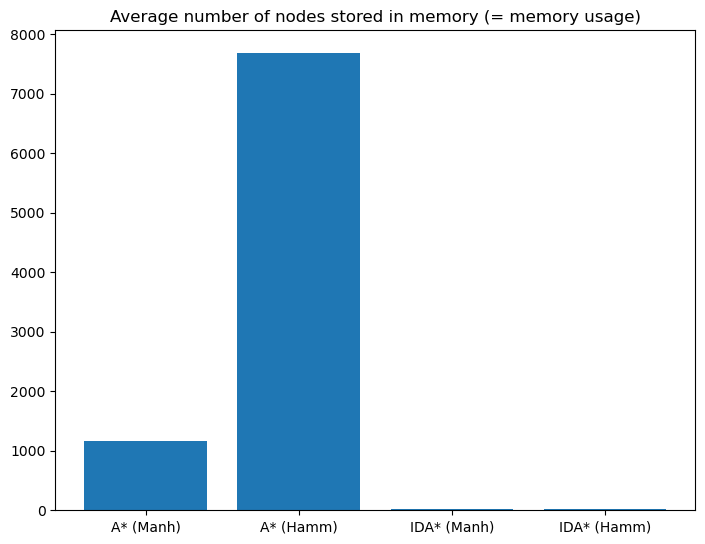

(1169.195652173913, 7680.489130434783, 19.72826086956522, 19.72826086956522)

In [24]:
fig = plt.figure()
ax = fig.add_axes([0, 0, 1, 1])
ax.set_title("Average number of nodes stored in memory (= memory usage)")
alg = ["A* (Manh)", "A* (Hamm)", "IDA* (Manh)", "IDA* (Hamm)"]
mem = [astar_manh_mem, astar_hamm_mem, idastar_manh_mem, idastar_hamm_mem]
ax.bar(alg, mem)
plt.show()

astar_manh_mem, astar_hamm_mem, idastar_manh_mem, idastar_hamm_mem

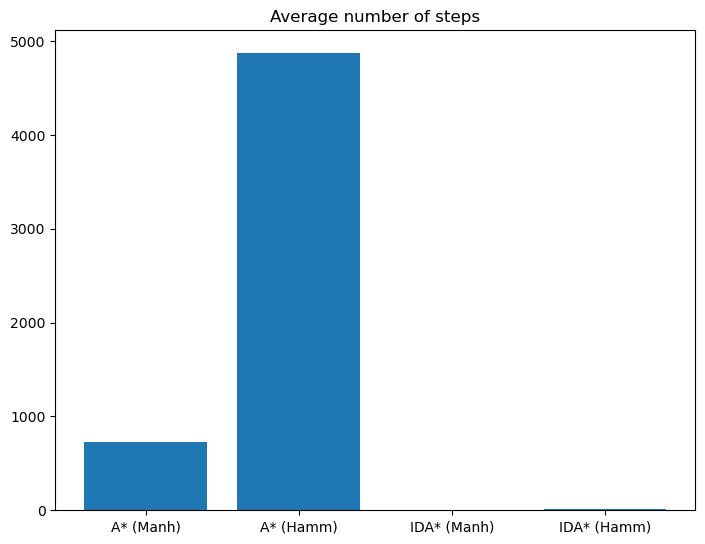

(727.8913043478261, 4873.45652173913, 5.184782608695652, 13.304347826086957)

In [25]:
fig = plt.figure()
ax = fig.add_axes([0, 0, 1, 1])
ax.set_title("Average number of steps")
alg = ["A* (Manh)", "A* (Hamm)", "IDA* (Manh)", "IDA* (Hamm)"]
sts = [astar_manh_steps, astar_hamm_steps, idastar_manh_steps, idastar_hamm_steps]
ax.bar(alg, sts)
plt.show()

astar_manh_steps, astar_hamm_steps, idastar_manh_steps, idastar_hamm_steps

Как можно видеть из полученных результатов, несмотря на большее время работы, idastar, как и ожидалось, значительно оптимальнее astar по памяти (как по измеренным параметрам памяти, так и по размеру дерева). Также значительно меньшим является среднее число сделанных шагов (однако сравнение этой величины между алгоритмами не кажется корректным из-за принципиально разного типа "шагов"). Дополнительно можно сделать вывод о том, что манхэттенская эвристика является предпочтительной в сравнении с эвристикой хэмминга для обоих алгоритмов: она дает значимое улучшение как по времени, так и по памяти. 